In [397]:
# Import Dependencies
%matplotlib inline

# Start Python Imports
import math, time, random, datetime

# Data Manipulation
import numpy as np
import pandas as pd

# Visualization 
import matplotlib.pyplot as plt
import missingno
import seaborn as sns
plt.style.use('seaborn-whitegrid')

# Preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize

# Machine learning
import catboost
from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier, Pool, cv

# Let's be rebels and ignore warnings for now
import warnings
warnings.filterwarnings('ignore')

## loading data

In [398]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
gender_submission = pd.read_csv("data/gender_submission.csv")

# view data


In [399]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [400]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [401]:
gender_submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


# data description

Survival: 0 = No, 1 = Yes

pclass (Ticket class): 1 = 1st, 2 = 2nd, 3 = 3rd

sex: Sex

Age: Age in years

sibsp: number of siblings/spouses aboard the Titanic

parch: number of parents/children aboard the Titanic

ticket: Ticket number

fare: Passenger fare

cabin: Cabin number

embarked: Port of Embarkation, C = Cherbourg, Q = Queenstown, S = Southampton
    

In [402]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


# check missing data

In [403]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


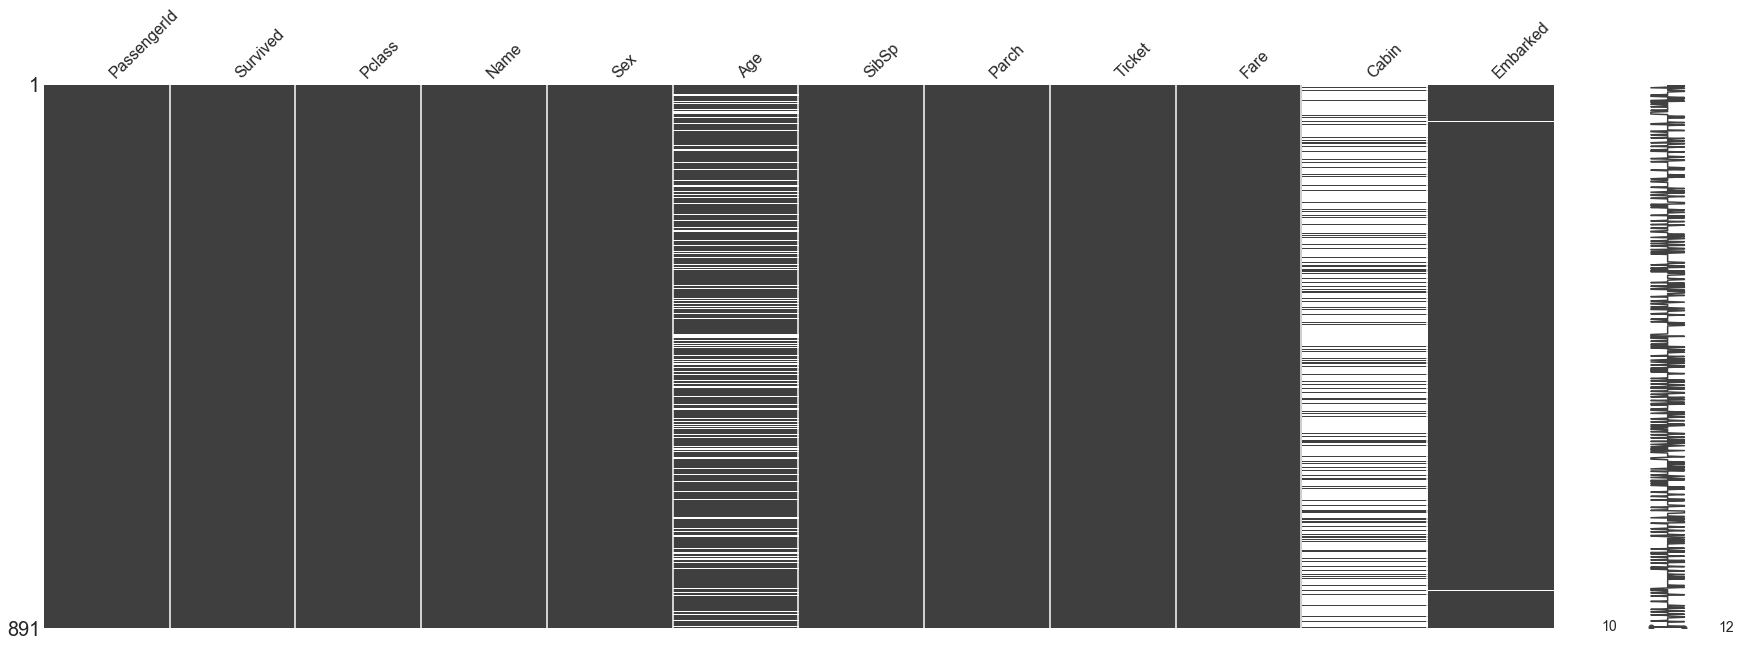

In [404]:
#plot missing data
missingno.matrix(train, figsize = (30,10))

In [405]:
missing_data = train.isnull().sum()

In [406]:
missing_data

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

# perfrom in depth analysis

In [407]:
df_bin = pd.DataFrame() # for discretised continuous variables
df_con = pd.DataFrame() # for continuous variables

# data types in data

In [408]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

# explore data individually

# target feature : survived

description : did the passenger survived

key : 1 = survived, 0 = not survived

0    549
1    342
Name: Survived, dtype: int64


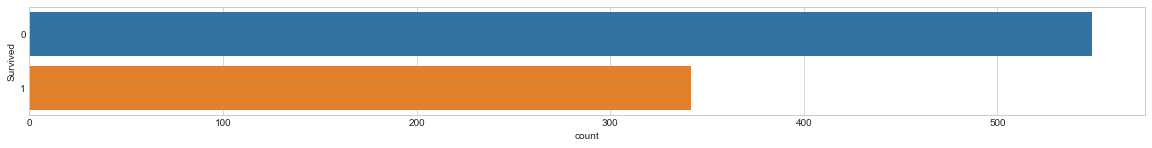

In [409]:
#how many people survived?
fig = plt.figure(figsize = (20,2))
sns.countplot(y = "Survived", data = train)
print(train.Survived.value_counts())

In [410]:
#add to subset dataframes
df_bin['Survived'] = train['Survived']
df_con['Survived'] = train['Survived']

In [411]:
df_bin.head()

,Survived
0,0
1,1
2,1
3,1
4,0


In [412]:
df_con.head()

,Survived
0,0
1,1
2,1
3,1
4,0


# target feature : Pclass

description : the ticket class of the passenger

key : 1 = 1st class, 2 = 2nd class, 3 = 3rd class 

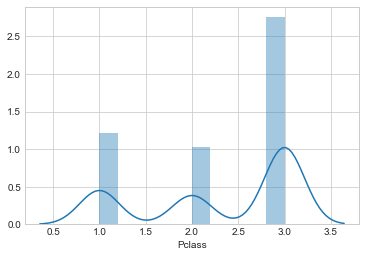

In [413]:
sns.distplot(train.Pclass)

we can see that the values are numerical but they are categorical

how do we know this? a passanger in class 3 != passenger in class 2

In [414]:
# how many missing values?
missing_data['Pclass']

0

since there are no mising values , we add it to our sub categories

In [415]:
df_bin['Pclass'] = train['Pclass']
df_con['Pclass'] = train['Pclass']

In [416]:
df_bin.head()

,Survived,Pclass
0,0,3
1,1,1
2,1,3
3,1,1
4,0,3


# target feature : Name

description : name of the passenger

In [417]:
#how many different names?
train.Name.value_counts()

Klaber, Mr. Herman               1
Ohman, Miss. Velin               1
Fortune, Mr. Mark                1
Jensen, Mr. Hans Peder           1
Beckwith, Mr. Richard Leonard    1
                                ..
Sivola, Mr. Antti Wilhelm        1
McEvoy, Mr. Michael              1
Mellors, Mr. William John        1
Carter, Mr. William Ernest       1
Panula, Master. Eino Viljami     1
Name: Name, Length: 891, dtype: int64

In [418]:
len(train)

891

# target feature : sex

description : sex of passenger

In [419]:
#how many missing values?
missing_data['Sex']

0

In [420]:
#add it to subset dataframe
df_bin['Sex'] = train['Sex']
df_con['Sex'] = train['Sex']

In [421]:
df_bin['Sex'] = np.where(df_bin['Sex'] == 'female', 1,0)

In [422]:
df_bin.head()

,Survived,Pclass,Sex
0,0,3,0
1,1,1,1
2,1,3,1
3,1,1,1
4,0,3,0


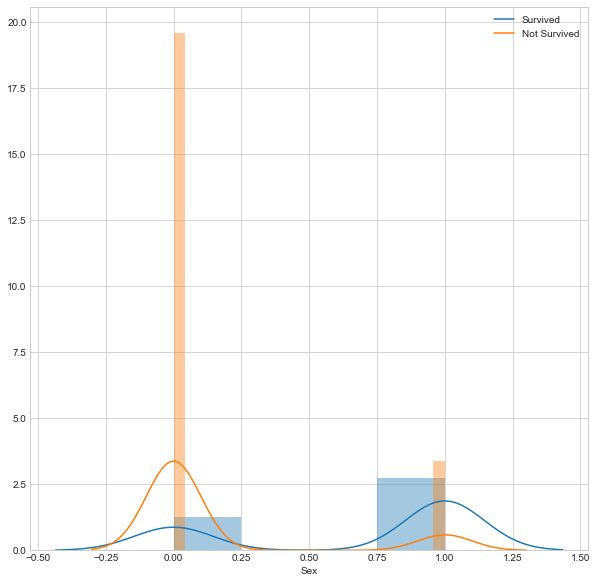

In [423]:
# how does sex column look compared to survived?
fig = plt.figure(figsize = (10,10))
sns.distplot(df_bin.loc[df_bin['Survived']==1]['Sex'], kde_kws={'label':'Survived'})
sns.distplot(df_bin.loc[df_bin['Survived']==0]['Sex'], kde_kws={'label':'Not Survived'})

0 = males, 1 = females

not many people survived but those who did, more were female.

# target feature: Age

description : age of passenger

In [424]:
#how many missing values?
missing_data['Age']

177

In [425]:
#after filling age values add to df_bin and df_con
#df_bin['Age'] = pd.cut(train['Age'], 10) # bucketed/binned into different categories
#df_con['Age'] = train['Age'] # non-bucketed

In [426]:
def plot_count_dist(data, bin_df, label_column, target_column, figsize=(20, 5), use_bin_df=False):
    """
    Function to plot counts and distributions of a label variable and 
    target variable side by side.
    ::param_data:: = target dataframe
    ::param_bin_df:: = binned dataframe for countplot
    ::param_label_column:: = binary labelled column
    ::param_target_column:: = column you want to view counts and distributions
    ::param_figsize:: = size of figure (width, height)
    ::param_use_bin_df:: = whether or not to use the bin_df, default False
    """
    if use_bin_df: 
        fig = plt.figure(figsize=figsize)
        plt.subplot(1, 2, 1)
        sns.countplot(y=target_column, data=bin_df);
        plt.subplot(1, 2, 2)
        sns.distplot(data.loc[data[label_column] == 1][target_column], 
                     kde_kws={"label": "Survived"});
        sns.distplot(data.loc[data[label_column] == 0][target_column], 
                     kde_kws={"label": "Did not survive"});
    else:
        fig = plt.figure(figsize=figsize)
        plt.subplot(1, 2, 1)
        sns.countplot(y=target_column, data=data);
        plt.subplot(1, 2, 2)
        sns.distplot(data.loc[data[label_column] == 1][target_column], 
                     kde_kws={"label": "Survived"});
        sns.distplot(data.loc[data[label_column] == 0][target_column], 
                     kde_kws={"label": "Did not survive"});

# target feature: SibSp

description : number of siblings/spouse of the passenger on titanic

In [427]:
#how many missing values?
missing_data['SibSp']

0

In [428]:
#what are the values?
train['SibSp'].value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

lets add the column to sub dataset

In [429]:
#add to sub dataframes
df_bin['SibSp'] = train['SibSp']
df_con['SibSp'] = train['SibSp']

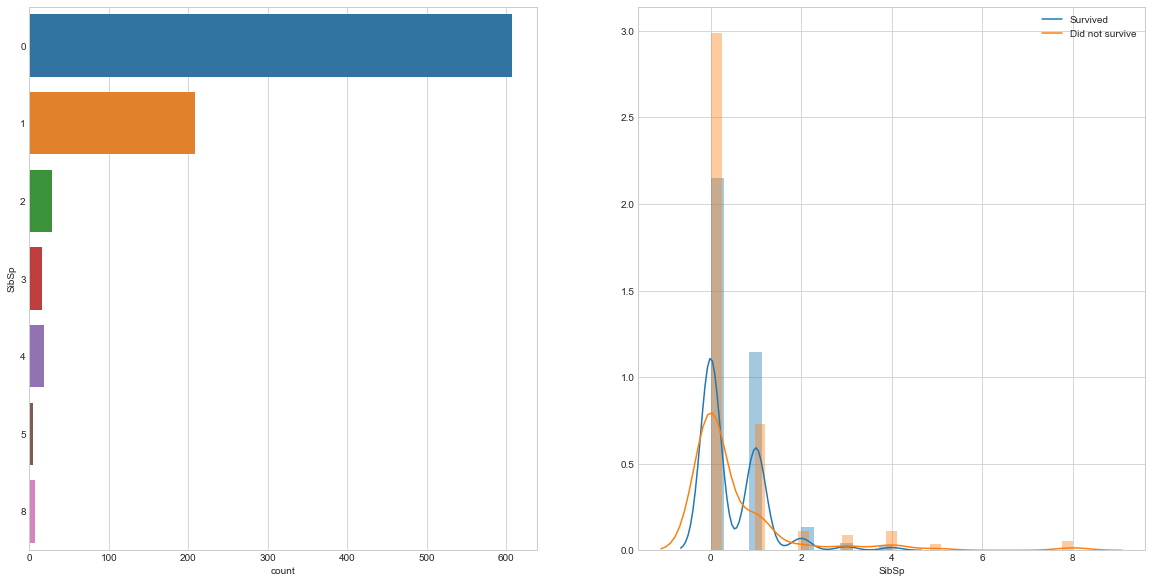

In [430]:
#visualization of SibSp and the distribution values against survived
plot_count_dist(train, bin_df = df_bin, label_column='Survived', target_column='SibSp',figsize=(20,10))

chances of survival with 1 sibling/spouse is more than that with 0

# target feature : Parch

description : number of childern that passenger got on board

In [431]:
#how many missing values?
missing_data['Parch']

0

In [432]:
#what are the values?
train['Parch'].value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

In [433]:
#add to sub dataframes
df_bin['Parch'] = train['Parch']
df_con['Parch'] = train['Parch']

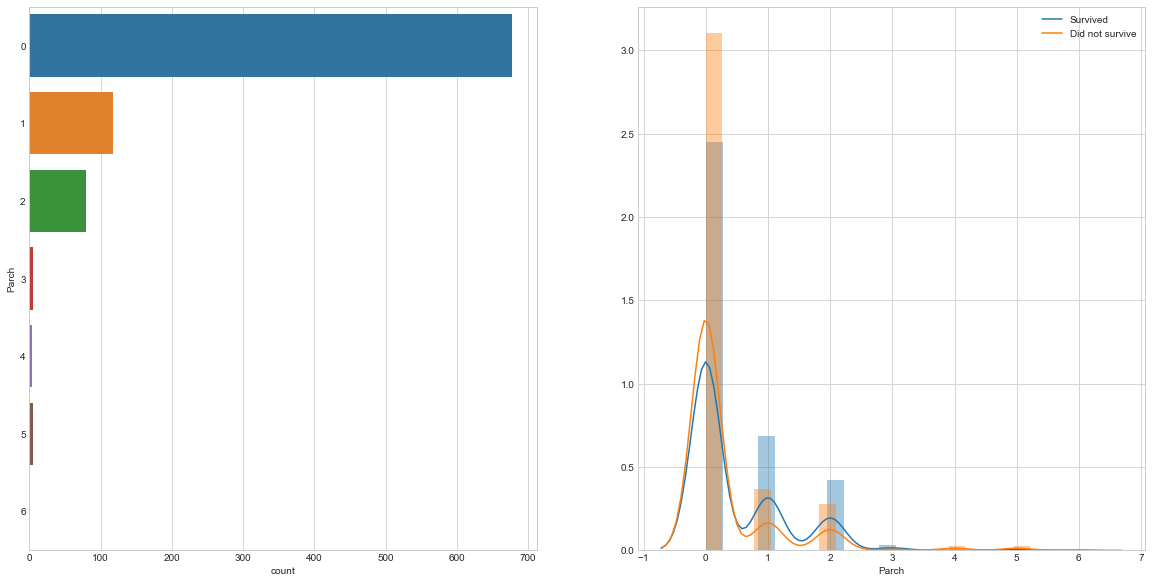

In [434]:
#visualization of SibSp and the distribution values against survived
plot_count_dist(train, bin_df = df_bin, label_column='Survived', target_column='Parch',figsize=(20,10))

chances of survival with 1 or 2 childern is more than that with 0 childer

# feature target : Ticket

description : the ticket number of passenger

In [435]:
#how many missing values?
missing_data['Ticket']

0

In [436]:
#how many kinds of tickets are there?
train['Ticket'].value_counts()

347082        7
CA. 2343      7
1601          7
CA 2144       6
3101295       6
             ..
226593        1
A./5. 3235    1
315093        1
27042         1
2631          1
Name: Ticket, Length: 681, dtype: int64

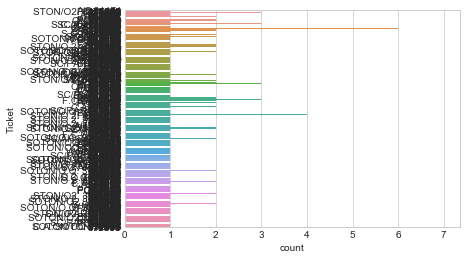

In [437]:
sns.countplot(y='Ticket', data = train )

In [438]:
#how many different tickets values are there?
print(len(train.Ticket.unique()))

681


# target feature : Fare

description : How much the ticket cost?

In [439]:
#how many missing values?
missing_data['Fare']

0

In [440]:
train['Fare'].value_counts()

8.0500     43
13.0000    42
7.8958     38
7.7500     34
26.0000    31
           ..
8.4583      1
9.8375      1
8.3625      1
14.1083     1
17.4000     1
Name: Fare, Length: 248, dtype: int64

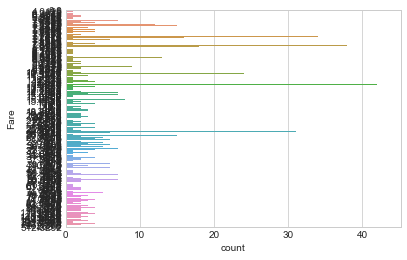

In [441]:
sns.countplot(y='Fare', data = train )

In [442]:
#add fare to sub dataframes
df_con['Fare'] = train['Fare']
df_bin['Fare'] = pd.cut(train['Fare'], bins= 5)

In [443]:
df_bin['Fare'].value_counts()

(-0.512, 102.466]     838
(102.466, 204.932]     33
(204.932, 307.398]     17
(409.863, 512.329]      3
(307.398, 409.863]      0
Name: Fare, dtype: int64

In [444]:
df_con.head()

,Survived,Pclass,Sex,SibSp,Parch,Fare
0,0,3,male,1,0,7.2500
1,1,1,female,1,0,71.2833
2,1,3,female,0,0,7.9250
3,1,1,female,1,0,53.1000
4,0,3,male,0,0,8.0500


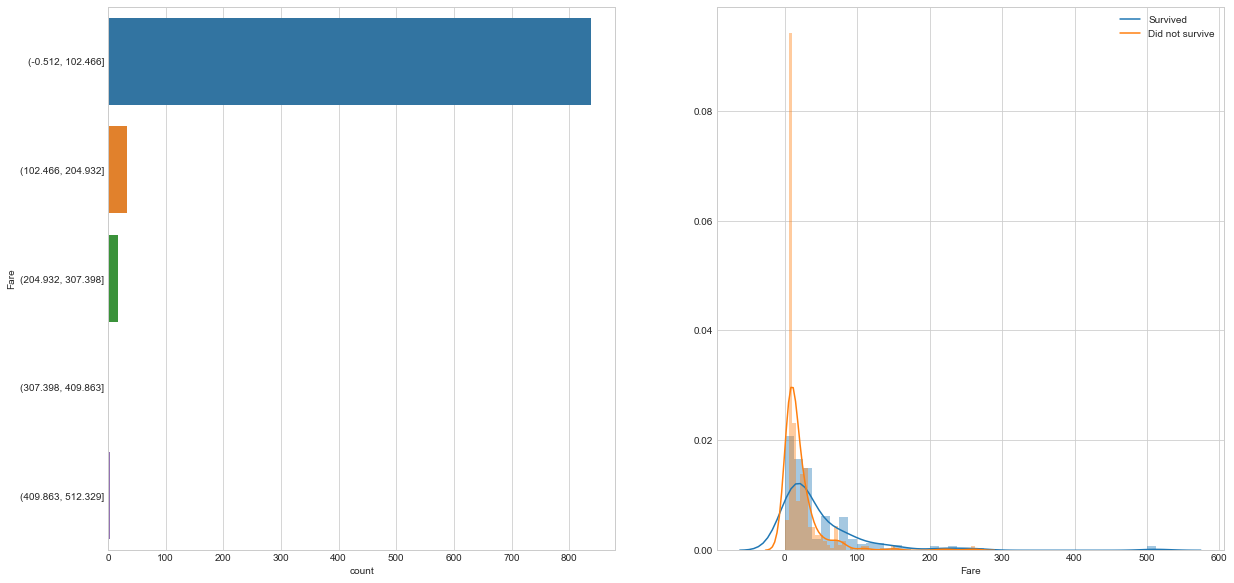

In [445]:
#visualize the fare bins counts as well as the fare distribution with survived
plot_count_dist(train, bin_df = df_bin, label_column='Survived', target_column='Fare',figsize=(20,10), use_bin_df = True)

lower the fare higher the chance of dying

# target feature : Cabin

description : cabin number of passenger

In [446]:
#how many missing values?
missing_data['Cabin']

687

In [447]:
train.Cabin.value_counts()

B96 B98        4
G6             4
C23 C25 C27    4
D              3
E101           3
              ..
B39            1
B79            1
B78            1
C103           1
B3             1
Name: Cabin, Length: 147, dtype: int64

too many missing values

not usable in starting values

# target feature : Embarked

description : the port from where the passenger boarded the titanic

key : Port of Embarkation, C = Cherbourg, Q = Queenstown, S = Southampton

In [448]:
#how many missing values?
missing_data['Embarked']

2

In [449]:
#how many values in embarked?
train['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

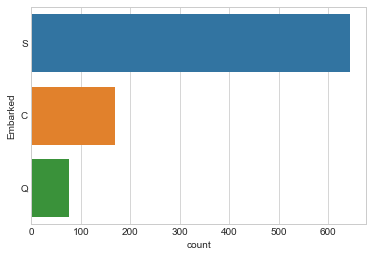

In [450]:
# what do the counts look like?
sns.countplot(y = 'Embarked' , data = train )

## dealing with missing values

drop those 2 rows

In [451]:
#add Embarked to sub dataframes
df_bin['Embarked'] = train['Embarked']
df_con['Embarked'] = train['Embarked']

In [452]:
#remove rows with missing values
print(len(df_con))
df_con = df_con.dropna(subset=['Embarked'])
df_bin = df_bin.dropna(subset=['Embarked'])
print(len(df_con))

891
889


In [453]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [454]:
df_bin.head()

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked
0,0,3,0,1,0,"(-0.512, 102.466]",S
1,1,1,1,1,0,"(-0.512, 102.466]",C
2,1,3,1,0,0,"(-0.512, 102.466]",S
3,1,1,1,1,0,"(-0.512, 102.466]",S
4,0,3,0,0,0,"(-0.512, 102.466]",S


In [455]:
df_con.head()

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked
0,0,3,male,1,0,7.2500,S
1,1,1,female,1,0,71.2833,C
2,1,3,female,0,0,7.9250,S
3,1,1,female,1,0,53.1000,S
4,0,3,male,0,0,8.0500,S


----

# feature encoding

feature encoding is done to make data ready to be fead into the model

In [456]:
#one hopt encoding the binned variable
one_hot_cols = df_bin.columns.tolist()
one_hot_cols.remove("Survived")
df_bin_enc = pd.get_dummies(df_bin, columns=one_hot_cols)


df_bin_enc.head()

,Survived,Pclass_1,Pclass_2,Pclass_3,Sex_0,Sex_1,SibSp_0,SibSp_1,SibSp_2,SibSp_3,...,Parch_5,Parch_6,"Fare_(-0.512, 102.466]","Fare_(102.466, 204.932]","Fare_(204.932, 307.398]","Fare_(307.398, 409.863]","Fare_(409.863, 512.329]",Embarked_C,Embarked_Q,Embarked_S
0,0,0,0,1,1,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
1,1,1,0,0,0,1,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0
2,1,0,0,1,0,1,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1
3,1,1,0,0,0,1,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
4,0,0,0,1,1,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1


In [457]:
df_con.head()

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked
0,0,3,male,1,0,7.2500,S
1,1,1,female,1,0,71.2833,C
2,1,3,female,0,0,7.9250,S
3,1,1,female,1,0,53.1000,S
4,0,3,male,0,0,8.0500,S


In [458]:
#label encode all continous values using LabelEncoder()
df_con_enc = df_con.apply(LabelEncoder().fit_transform)

df_con_enc.head()

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked
0,0,2,1,1,0,18,2
1,1,0,0,1,0,207,0
2,1,2,0,0,0,41,2
3,1,0,0,1,0,189,2
4,0,2,1,0,0,43,2


----

# machine learning model

## seperate the data

In [459]:
#selected dataframe
selected_df = df_con_enc

In [460]:
#split in label and data
X_train = selected_df.drop('Survived', axis = 1) #data
y_train = selected_df.Survived #labels

In [461]:
#shape of x_train
X_train.head()

,Pclass,Sex,SibSp,Parch,Fare,Embarked
0,2,1,1,0,18,2
1,0,0,1,0,207,0
2,2,0,0,0,41,2
3,0,0,1,0,189,2
4,2,1,0,0,43,2


In [462]:
#shape of y_train
y_train.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [463]:
# Function that runs the requested algorithm and returns the accuracy metrics
def fit_ml_algo(algo, X_train, y_train, cv):
    
    # One Pass
    model = algo.fit(X_train, y_train)
    acc = round(model.score(X_train, y_train) * 100, 2)
    
    # Cross Validation 
    train_pred = model_selection.cross_val_predict(algo, 
                                                  X_train, 
                                                  y_train, 
                                                  cv=cv, 
                                                  n_jobs = -1)
    # Cross-validation accuracy metric
    acc_cv = round(metrics.accuracy_score(y_train, train_pred) * 100, 2)
    
    return train_pred, acc, acc_cv

----

# logistic regression

In [464]:
#logistic regression
start_time = time.time()
train_pred_log, acc_log, acc_cv_log = fit_ml_algo(LogisticRegression(),X_train, y_train, 10)

log_time = (time.time() - start_time)
print("Accuracy: %s" % acc_log)
print("Accuracy CV 10-Fold: %s" % acc_cv_log)
print("Running Time: %s" % datetime.timedelta(seconds=log_time))

Accuracy: 79.08
Accuracy CV 10-Fold: 78.52
Running Time: 0:00:12.674299


----

# K-nearest Neighbours

In [465]:
#K-nearest Neighbours
start_time = time.time()
train_pred_log, acc_knn, acc_cv_knn = fit_ml_algo(KNeighborsClassifier(),X_train, y_train, 10)

log_time = (time.time() - start_time)
print("Accuracy: %s" % acc_knn)
print("Accuracy CV 10-Fold: %s" % acc_cv_knn)
print("Running Time: %s" % datetime.timedelta(seconds=log_time))

Accuracy: 81.44
Accuracy CV 10-Fold: 73.68
Running Time: 0:00:00.254811


----

# Linear support vector machine(SVC)

In [466]:
#Linear SVC
start_time = time.time()
train_pred_log, acc_linear_svc, acc_cv_linear_svc = fit_ml_algo(LinearSVC(),X_train, y_train, 10)

log_time = (time.time() - start_time)
print("Accuracy: %s" % acc_linear_svc)
print("Accuracy CV 10-Fold: %s" % acc_cv_linear_svc)
print("Running Time: %s" % datetime.timedelta(seconds=log_time))

Accuracy: 71.77
Accuracy CV 10-Fold: 69.63
Running Time: 0:00:00.211397


----

# Gradient Boosting tree

In [467]:
#gradient boosting tree
start_time = time.time()
train_pred_log, acc_gbt, acc_cv_gbt = fit_ml_algo(GradientBoostingClassifier(),X_train, y_train, 10)

log_time = (time.time() - start_time)
print("Accuracy: %s" % acc_gbt)
print("Accuracy CV 10-Fold: %s" % acc_cv_gbt)
print("Running Time: %s" % datetime.timedelta(seconds=log_time))

Accuracy: 86.39
Accuracy CV 10-Fold: 81.1
Running Time: 0:00:00.433777


----

# Gaussian Naive Bayes

In [468]:
#gaussian Naive Bayes
start_time = time.time()
train_pred_log, acc_gaussian, acc_cv_gaussian = fit_ml_algo(GaussianNB(),X_train, y_train, 10)

log_time = (time.time() - start_time)
print("Accuracy: %s" % acc_gaussian)
print("Accuracy CV 10-Fold: %s" % acc_cv_gaussian)
print("Running Time: %s" % datetime.timedelta(seconds=log_time))

Accuracy: 76.72
Accuracy CV 10-Fold: 76.38
Running Time: 0:00:00.036934


----

# Stochastic Gradient Descent

In [469]:
#SGD classifier
start_time = time.time()
train_pred_log, acc_sgd, acc_cv_sgd = fit_ml_algo(SGDClassifier(),X_train, y_train, 10)

log_time = (time.time() - start_time)
print("Accuracy: %s" % acc_sgd)
print("Accuracy CV 10-Fold: %s" % acc_cv_sgd)
print("Running Time: %s" % datetime.timedelta(seconds=log_time))

Accuracy: 61.75
Accuracy CV 10-Fold: 66.03
Running Time: 0:00:00.055852


----

# Decision Tree Classifier

In [470]:
#Decision tress Classifier
start_time = time.time()
train_pred_log, acc_dt, acc_cv_dt = fit_ml_algo(DecisionTreeClassifier(),X_train, y_train, 10)

log_time = (time.time() - start_time)
print("Accuracy: %s" % acc_dt)
print("Accuracy CV 10-Fold: %s" % acc_cv_dt)
print("Running Time: %s" % datetime.timedelta(seconds=log_time))

Accuracy: 92.46
Accuracy CV 10-Fold: 79.19
Running Time: 0:00:00.049868


----

# CatBoost Algorithm

In [471]:
#view trainig data
X_train.head()

,Pclass,Sex,SibSp,Parch,Fare,Embarked
0,2,1,1,0,18,2
1,0,0,1,0,207,0
2,2,0,0,0,41,2
3,0,0,1,0,189,2
4,2,1,0,0,43,2


In [472]:
#view train label
y_train.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [473]:
#define the categorical features for the catboost model
cat_features = np.where(X_train.dtypes != np.float)[0]
cat_features

array([0, 1, 2, 3, 4, 5], dtype=int64)

this means only fare will be treated as categorical

In [474]:
#use the CatBoost Pool() function to pool together the training data and categorical feature labels
train_pool = Pool(X_train, y_train, cat_features)

In [475]:
# CatBoost model definition
catboost_model = CatBoostClassifier(iterations=1000,
                                    custom_loss=['Accuracy'],
                                    loss_function='Logloss')

# Fit CatBoost model
catboost_model.fit(train_pool,
                   plot=True)

# CatBoost accuracy
acc_catboost = round(catboost_model.score(X_train, y_train) * 100, 2)

Learning rate set to 0.016206
0:	learn: 0.6838699	total: 28.5ms	remaining: 28.5s
1:	learn: 0.6753070	total: 56.7ms	remaining: 28.3s
2:	learn: 0.6664907	total: 92.7ms	remaining: 30.8s
3:	learn: 0.6580711	total: 121ms	remaining: 30.2s
4:	learn: 0.6509907	total: 144ms	remaining: 28.6s
5:	learn: 0.6428456	total: 175ms	remaining: 29s
6:	learn: 0.6358374	total: 212ms	remaining: 30s
7:	learn: 0.6285425	total: 253ms	remaining: 31.4s
8:	learn: 0.6215779	total: 291ms	remaining: 32.1s
9:	learn: 0.6151968	total: 328ms	remaining: 32.4s
10:	learn: 0.6090478	total: 354ms	remaining: 31.8s
11:	learn: 0.6030273	total: 381ms	remaining: 31.4s
12:	learn: 0.5975315	total: 419ms	remaining: 31.8s
13:	learn: 0.5918302	total: 459ms	remaining: 32.4s
14:	learn: 0.5864084	total: 492ms	remaining: 32.3s
15:	learn: 0.5819175	total: 515ms	remaining: 31.6s
16:	learn: 0.5766028	total: 552ms	remaining: 31.9s
17:	learn: 0.5726184	total: 582ms	remaining: 31.8s
18:	learn: 0.5680301	total: 603ms	remaining: 31.1s
19:	learn: 0

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

20:	learn: 0.5593913	total: 674ms	remaining: 31.4s
21:	learn: 0.5551887	total: 709ms	remaining: 31.5s
22:	learn: 0.5514062	total: 735ms	remaining: 31.2s
23:	learn: 0.5473766	total: 773ms	remaining: 31.4s
24:	learn: 0.5437270	total: 794ms	remaining: 31s
25:	learn: 0.5398505	total: 833ms	remaining: 31.2s
26:	learn: 0.5364056	total: 863ms	remaining: 31.1s
27:	learn: 0.5330146	total: 896ms	remaining: 31.1s
28:	learn: 0.5295665	total: 937ms	remaining: 31.4s
29:	learn: 0.5262067	total: 984ms	remaining: 31.8s
30:	learn: 0.5231328	total: 1.01s	remaining: 31.6s
31:	learn: 0.5197970	total: 1.05s	remaining: 31.7s
32:	learn: 0.5173964	total: 1.09s	remaining: 31.9s
33:	learn: 0.5140603	total: 1.13s	remaining: 32s
34:	learn: 0.5108740	total: 1.17s	remaining: 32.1s
35:	learn: 0.5078704	total: 1.21s	remaining: 32.4s
36:	learn: 0.5062464	total: 1.23s	remaining: 32.1s
37:	learn: 0.5037133	total: 1.27s	remaining: 32.2s
38:	learn: 0.5012685	total: 1.3s	remaining: 32.2s
39:	learn: 0.4992743	total: 1.34s	re

184:	learn: 0.4122352	total: 5.41s	remaining: 23.8s
185:	learn: 0.4121208	total: 5.43s	remaining: 23.8s
186:	learn: 0.4120520	total: 5.45s	remaining: 23.7s
187:	learn: 0.4119839	total: 5.47s	remaining: 23.6s
188:	learn: 0.4119515	total: 5.48s	remaining: 23.5s
189:	learn: 0.4119477	total: 5.5s	remaining: 23.4s
190:	learn: 0.4118782	total: 5.52s	remaining: 23.4s
191:	learn: 0.4114546	total: 5.54s	remaining: 23.3s
192:	learn: 0.4113299	total: 5.56s	remaining: 23.2s
193:	learn: 0.4110511	total: 5.59s	remaining: 23.2s
194:	learn: 0.4109345	total: 5.61s	remaining: 23.1s
195:	learn: 0.4108509	total: 5.63s	remaining: 23.1s
196:	learn: 0.4106772	total: 5.66s	remaining: 23.1s
197:	learn: 0.4106355	total: 5.67s	remaining: 23s
198:	learn: 0.4105039	total: 5.7s	remaining: 23s
199:	learn: 0.4104646	total: 5.72s	remaining: 22.9s
200:	learn: 0.4104626	total: 5.74s	remaining: 22.8s
201:	learn: 0.4103252	total: 5.75s	remaining: 22.7s
202:	learn: 0.4101513	total: 5.77s	remaining: 22.7s
203:	learn: 0.4100

347:	learn: 0.3950075	total: 9.63s	remaining: 18s
348:	learn: 0.3949261	total: 9.67s	remaining: 18s
349:	learn: 0.3948790	total: 9.7s	remaining: 18s
350:	learn: 0.3948721	total: 9.71s	remaining: 17.9s
351:	learn: 0.3948589	total: 9.72s	remaining: 17.9s
352:	learn: 0.3948406	total: 9.74s	remaining: 17.9s
353:	learn: 0.3946202	total: 9.77s	remaining: 17.8s
354:	learn: 0.3944388	total: 9.8s	remaining: 17.8s
355:	learn: 0.3944293	total: 9.82s	remaining: 17.8s
356:	learn: 0.3944293	total: 9.83s	remaining: 17.7s
357:	learn: 0.3943055	total: 9.87s	remaining: 17.7s
358:	learn: 0.3941936	total: 9.9s	remaining: 17.7s
359:	learn: 0.3940117	total: 9.94s	remaining: 17.7s
360:	learn: 0.3937313	total: 9.96s	remaining: 17.6s
361:	learn: 0.3936711	total: 9.99s	remaining: 17.6s
362:	learn: 0.3935483	total: 10s	remaining: 17.6s
363:	learn: 0.3935419	total: 10s	remaining: 17.6s
364:	learn: 0.3934832	total: 10.1s	remaining: 17.5s
365:	learn: 0.3934528	total: 10.1s	remaining: 17.5s
366:	learn: 0.3934372	tot

509:	learn: 0.3816234	total: 14.5s	remaining: 14s
510:	learn: 0.3813172	total: 14.6s	remaining: 14s
511:	learn: 0.3813001	total: 14.6s	remaining: 13.9s
512:	learn: 0.3808828	total: 14.7s	remaining: 13.9s
513:	learn: 0.3806622	total: 14.7s	remaining: 13.9s
514:	learn: 0.3804792	total: 14.8s	remaining: 13.9s
515:	learn: 0.3804490	total: 14.8s	remaining: 13.9s
516:	learn: 0.3804082	total: 14.8s	remaining: 13.9s
517:	learn: 0.3802327	total: 14.9s	remaining: 13.8s
518:	learn: 0.3801872	total: 14.9s	remaining: 13.8s
519:	learn: 0.3800374	total: 15s	remaining: 13.8s
520:	learn: 0.3798890	total: 15s	remaining: 13.8s
521:	learn: 0.3798683	total: 15s	remaining: 13.7s
522:	learn: 0.3798369	total: 15s	remaining: 13.7s
523:	learn: 0.3795123	total: 15.1s	remaining: 13.7s
524:	learn: 0.3795052	total: 15.1s	remaining: 13.7s
525:	learn: 0.3794015	total: 15.1s	remaining: 13.6s
526:	learn: 0.3793838	total: 15.1s	remaining: 13.6s
527:	learn: 0.3791994	total: 15.2s	remaining: 13.6s
528:	learn: 0.3789892	to

671:	learn: 0.3588949	total: 20.4s	remaining: 9.96s
672:	learn: 0.3588347	total: 20.4s	remaining: 9.93s
673:	learn: 0.3586746	total: 20.5s	remaining: 9.9s
674:	learn: 0.3585569	total: 20.5s	remaining: 9.88s
675:	learn: 0.3584925	total: 20.5s	remaining: 9.84s
676:	learn: 0.3583709	total: 20.6s	remaining: 9.81s
677:	learn: 0.3583335	total: 20.6s	remaining: 9.79s
678:	learn: 0.3583039	total: 20.6s	remaining: 9.76s
679:	learn: 0.3582690	total: 20.7s	remaining: 9.73s
680:	learn: 0.3581636	total: 20.7s	remaining: 9.7s
681:	learn: 0.3581250	total: 20.7s	remaining: 9.67s
682:	learn: 0.3580445	total: 20.8s	remaining: 9.64s
683:	learn: 0.3578690	total: 20.8s	remaining: 9.61s
684:	learn: 0.3577546	total: 20.8s	remaining: 9.58s
685:	learn: 0.3576482	total: 20.9s	remaining: 9.56s
686:	learn: 0.3576014	total: 20.9s	remaining: 9.53s
687:	learn: 0.3574716	total: 21s	remaining: 9.51s
688:	learn: 0.3574518	total: 21s	remaining: 9.48s
689:	learn: 0.3573600	total: 21s	remaining: 9.45s
690:	learn: 0.357252

830:	learn: 0.3412280	total: 26s	remaining: 5.28s
831:	learn: 0.3411496	total: 26s	remaining: 5.25s
832:	learn: 0.3409973	total: 26s	remaining: 5.22s
833:	learn: 0.3409591	total: 26.1s	remaining: 5.19s
834:	learn: 0.3409129	total: 26.1s	remaining: 5.16s
835:	learn: 0.3406320	total: 26.1s	remaining: 5.13s
836:	learn: 0.3405577	total: 26.2s	remaining: 5.1s
837:	learn: 0.3404134	total: 26.2s	remaining: 5.07s
838:	learn: 0.3400534	total: 26.2s	remaining: 5.04s
839:	learn: 0.3399965	total: 26.3s	remaining: 5s
840:	learn: 0.3397731	total: 26.3s	remaining: 4.97s
841:	learn: 0.3396189	total: 26.3s	remaining: 4.94s
842:	learn: 0.3395506	total: 26.4s	remaining: 4.91s
843:	learn: 0.3395231	total: 26.4s	remaining: 4.88s
844:	learn: 0.3394531	total: 26.4s	remaining: 4.85s
845:	learn: 0.3393445	total: 26.5s	remaining: 4.82s
846:	learn: 0.3393195	total: 26.5s	remaining: 4.79s
847:	learn: 0.3392885	total: 26.5s	remaining: 4.76s
848:	learn: 0.3392658	total: 26.6s	remaining: 4.72s
849:	learn: 0.3391348	

991:	learn: 0.3265689	total: 31.8s	remaining: 256ms
992:	learn: 0.3265356	total: 31.8s	remaining: 224ms
993:	learn: 0.3265188	total: 31.9s	remaining: 192ms
994:	learn: 0.3262630	total: 31.9s	remaining: 160ms
995:	learn: 0.3262462	total: 32s	remaining: 128ms
996:	learn: 0.3260615	total: 32s	remaining: 96.3ms
997:	learn: 0.3260159	total: 32s	remaining: 64.2ms
998:	learn: 0.3259360	total: 32.1s	remaining: 32.1ms
999:	learn: 0.3257736	total: 32.1s	remaining: 0us


# perform cross validation on catboost


In [476]:
# How long will this take?
start_time = time.time()

# Set params for cross-validation as same as initial model
cv_params = catboost_model.get_params()

# Run the cross-validation for 10-folds (same as the other models)
cv_data = cv(train_pool,
             cv_params,
             fold_count=10,
             plot=True)

# How long did it take?
catboost_time = (time.time() - start_time)

# CatBoost CV results save into a dataframe (cv_data), let's withdraw the maximum accuracy score
acc_cv_catboost = round(np.max(cv_data['test-Accuracy-mean']) * 100, 2)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6766682	test: 0.6764602	best: 0.6764602 (0)	total: 878ms	remaining: 14m 36s
1:	learn: 0.6601036	test: 0.6600386	best: 0.6600386 (1)	total: 1.83s	remaining: 15m 12s
2:	learn: 0.6459986	test: 0.6462400	best: 0.6462400 (2)	total: 2.66s	remaining: 14m 43s
3:	learn: 0.6330671	test: 0.6330109	best: 0.6330109 (3)	total: 3.5s	remaining: 14m 30s
4:	learn: 0.6200741	test: 0.6201199	best: 0.6201199 (4)	total: 4.37s	remaining: 14m 28s
5:	learn: 0.6077950	test: 0.6084728	best: 0.6084728 (5)	total: 5.25s	remaining: 14m 29s
6:	learn: 0.5968765	test: 0.5976094	best: 0.5976094 (6)	total: 6.11s	remaining: 14m 26s
7:	learn: 0.5862899	test: 0.5872059	best: 0.5872059 (7)	total: 6.99s	remaining: 14m 26s
8:	learn: 0.5771903	test: 0.5781970	best: 0.5781970 (8)	total: 7.83s	remaining: 14m 22s
9:	learn: 0.5687181	test: 0.5700377	best: 0.5700377 (9)	total: 8.67s	remaining: 14m 18s
10:	learn: 0.5607507	test: 0.5619833	best: 0.5619833 (10)	total: 9.59s	remaining: 14m 22s
11:	learn: 0.5536804	test: 0.55

92:	learn: 0.4185431	test: 0.4417799	best: 0.4417531 (91)	total: 1m 19s	remaining: 12m 57s
93:	learn: 0.4181545	test: 0.4416881	best: 0.4416881 (93)	total: 1m 20s	remaining: 12m 56s
94:	learn: 0.4179635	test: 0.4415674	best: 0.4415674 (94)	total: 1m 21s	remaining: 12m 54s
95:	learn: 0.4177291	test: 0.4413643	best: 0.4413643 (95)	total: 1m 22s	remaining: 12m 52s
96:	learn: 0.4173115	test: 0.4409413	best: 0.4409413 (96)	total: 1m 22s	remaining: 12m 51s
97:	learn: 0.4169325	test: 0.4408607	best: 0.4408607 (97)	total: 1m 23s	remaining: 12m 50s
98:	learn: 0.4166032	test: 0.4405369	best: 0.4405369 (98)	total: 1m 24s	remaining: 12m 49s
99:	learn: 0.4162087	test: 0.4403265	best: 0.4403265 (99)	total: 1m 25s	remaining: 12m 48s
100:	learn: 0.4159642	test: 0.4402896	best: 0.4402896 (100)	total: 1m 26s	remaining: 12m 46s
101:	learn: 0.4155561	test: 0.4398224	best: 0.4398224 (101)	total: 1m 26s	remaining: 12m 45s
102:	learn: 0.4152214	test: 0.4394825	best: 0.4394825 (102)	total: 1m 27s	remaining: 1

181:	learn: 0.3996947	test: 0.4325983	best: 0.4325240 (178)	total: 2m 30s	remaining: 11m 17s
182:	learn: 0.3994487	test: 0.4323321	best: 0.4323321 (182)	total: 2m 31s	remaining: 11m 16s
183:	learn: 0.3992908	test: 0.4322797	best: 0.4322797 (183)	total: 2m 32s	remaining: 11m 15s
184:	learn: 0.3991954	test: 0.4321508	best: 0.4321508 (184)	total: 2m 33s	remaining: 11m 14s
185:	learn: 0.3990030	test: 0.4321251	best: 0.4321251 (185)	total: 2m 34s	remaining: 11m 13s
186:	learn: 0.3987737	test: 0.4322039	best: 0.4321251 (185)	total: 2m 34s	remaining: 11m 13s
187:	learn: 0.3986553	test: 0.4322438	best: 0.4321251 (185)	total: 2m 35s	remaining: 11m 11s
188:	learn: 0.3985417	test: 0.4323793	best: 0.4321251 (185)	total: 2m 36s	remaining: 11m 10s
189:	learn: 0.3984084	test: 0.4323037	best: 0.4321251 (185)	total: 2m 37s	remaining: 11m 10s
190:	learn: 0.3983370	test: 0.4322754	best: 0.4321251 (185)	total: 2m 37s	remaining: 11m 8s
191:	learn: 0.3981524	test: 0.4320790	best: 0.4320790 (191)	total: 2m 3

270:	learn: 0.3849961	test: 0.4298349	best: 0.4296378 (258)	total: 3m 43s	remaining: 10m 1s
271:	learn: 0.3847890	test: 0.4299360	best: 0.4296378 (258)	total: 3m 44s	remaining: 10m
272:	learn: 0.3846204	test: 0.4298264	best: 0.4296378 (258)	total: 3m 45s	remaining: 9m 59s
273:	learn: 0.3844557	test: 0.4298806	best: 0.4296378 (258)	total: 3m 46s	remaining: 9m 59s
274:	learn: 0.3842974	test: 0.4298950	best: 0.4296378 (258)	total: 3m 47s	remaining: 9m 58s
275:	learn: 0.3840723	test: 0.4297215	best: 0.4296378 (258)	total: 3m 47s	remaining: 9m 57s
276:	learn: 0.3839487	test: 0.4298018	best: 0.4296378 (258)	total: 3m 48s	remaining: 9m 57s
277:	learn: 0.3837356	test: 0.4298521	best: 0.4296378 (258)	total: 3m 49s	remaining: 9m 56s
278:	learn: 0.3835162	test: 0.4298050	best: 0.4296378 (258)	total: 3m 50s	remaining: 9m 55s
279:	learn: 0.3833423	test: 0.4298290	best: 0.4296378 (258)	total: 3m 51s	remaining: 9m 55s
280:	learn: 0.3829669	test: 0.4297315	best: 0.4296378 (258)	total: 3m 52s	remaining

360:	learn: 0.3649851	test: 0.4292182	best: 0.4286710 (348)	total: 5m 9s	remaining: 9m 7s
361:	learn: 0.3646741	test: 0.4291841	best: 0.4286710 (348)	total: 5m 10s	remaining: 9m 6s
362:	learn: 0.3644194	test: 0.4291920	best: 0.4286710 (348)	total: 5m 11s	remaining: 9m 5s
363:	learn: 0.3640954	test: 0.4291026	best: 0.4286710 (348)	total: 5m 11s	remaining: 9m 5s
364:	learn: 0.3638610	test: 0.4291814	best: 0.4286710 (348)	total: 5m 12s	remaining: 9m 4s
365:	learn: 0.3634278	test: 0.4291099	best: 0.4286710 (348)	total: 5m 13s	remaining: 9m 3s
366:	learn: 0.3631521	test: 0.4292222	best: 0.4286710 (348)	total: 5m 14s	remaining: 9m 3s
367:	learn: 0.3629444	test: 0.4293622	best: 0.4286710 (348)	total: 5m 15s	remaining: 9m 2s
368:	learn: 0.3626746	test: 0.4293157	best: 0.4286710 (348)	total: 5m 16s	remaining: 9m 1s
369:	learn: 0.3625151	test: 0.4293001	best: 0.4286710 (348)	total: 5m 17s	remaining: 9m 1s
370:	learn: 0.3622992	test: 0.4293002	best: 0.4286710 (348)	total: 5m 18s	remaining: 9m
371

450:	learn: 0.3470532	test: 0.4307186	best: 0.4286710 (348)	total: 6m 36s	remaining: 8m 2s
451:	learn: 0.3468206	test: 0.4307007	best: 0.4286710 (348)	total: 6m 37s	remaining: 8m 1s
452:	learn: 0.3466708	test: 0.4307162	best: 0.4286710 (348)	total: 6m 38s	remaining: 8m
453:	learn: 0.3464552	test: 0.4306481	best: 0.4286710 (348)	total: 6m 39s	remaining: 7m 59s
454:	learn: 0.3462929	test: 0.4306065	best: 0.4286710 (348)	total: 6m 40s	remaining: 7m 59s
455:	learn: 0.3461450	test: 0.4307932	best: 0.4286710 (348)	total: 6m 41s	remaining: 7m 58s
456:	learn: 0.3458893	test: 0.4306130	best: 0.4286710 (348)	total: 6m 41s	remaining: 7m 57s
457:	learn: 0.3457855	test: 0.4305997	best: 0.4286710 (348)	total: 6m 42s	remaining: 7m 56s
458:	learn: 0.3456811	test: 0.4306282	best: 0.4286710 (348)	total: 6m 43s	remaining: 7m 56s
459:	learn: 0.3453674	test: 0.4307288	best: 0.4286710 (348)	total: 6m 44s	remaining: 7m 55s
460:	learn: 0.3452330	test: 0.4307744	best: 0.4286710 (348)	total: 6m 45s	remaining: 7

540:	learn: 0.3320463	test: 0.4324235	best: 0.4286710 (348)	total: 8m 4s	remaining: 6m 51s
541:	learn: 0.3318866	test: 0.4323694	best: 0.4286710 (348)	total: 8m 5s	remaining: 6m 50s
542:	learn: 0.3317318	test: 0.4323817	best: 0.4286710 (348)	total: 8m 6s	remaining: 6m 49s
543:	learn: 0.3315996	test: 0.4323698	best: 0.4286710 (348)	total: 8m 7s	remaining: 6m 48s
544:	learn: 0.3314396	test: 0.4323638	best: 0.4286710 (348)	total: 8m 9s	remaining: 6m 48s
545:	learn: 0.3312813	test: 0.4323831	best: 0.4286710 (348)	total: 8m 9s	remaining: 6m 47s
546:	learn: 0.3310825	test: 0.4321871	best: 0.4286710 (348)	total: 8m 10s	remaining: 6m 46s
547:	learn: 0.3309926	test: 0.4322076	best: 0.4286710 (348)	total: 8m 11s	remaining: 6m 45s
548:	learn: 0.3308345	test: 0.4322107	best: 0.4286710 (348)	total: 8m 12s	remaining: 6m 44s
549:	learn: 0.3307572	test: 0.4321867	best: 0.4286710 (348)	total: 8m 13s	remaining: 6m 44s
550:	learn: 0.3305829	test: 0.4322754	best: 0.4286710 (348)	total: 8m 14s	remaining: 6

630:	learn: 0.3189481	test: 0.4346886	best: 0.4286710 (348)	total: 9m 38s	remaining: 5m 38s
631:	learn: 0.3188577	test: 0.4347595	best: 0.4286710 (348)	total: 9m 39s	remaining: 5m 37s
632:	learn: 0.3187015	test: 0.4348174	best: 0.4286710 (348)	total: 9m 40s	remaining: 5m 36s
633:	learn: 0.3184611	test: 0.4349241	best: 0.4286710 (348)	total: 9m 41s	remaining: 5m 35s
634:	learn: 0.3183278	test: 0.4350832	best: 0.4286710 (348)	total: 9m 42s	remaining: 5m 34s
635:	learn: 0.3182401	test: 0.4350786	best: 0.4286710 (348)	total: 9m 43s	remaining: 5m 33s
636:	learn: 0.3181356	test: 0.4351698	best: 0.4286710 (348)	total: 9m 44s	remaining: 5m 33s
637:	learn: 0.3180294	test: 0.4351484	best: 0.4286710 (348)	total: 9m 45s	remaining: 5m 32s
638:	learn: 0.3179340	test: 0.4352379	best: 0.4286710 (348)	total: 9m 47s	remaining: 5m 31s
639:	learn: 0.3178158	test: 0.4352526	best: 0.4286710 (348)	total: 9m 48s	remaining: 5m 30s
640:	learn: 0.3177272	test: 0.4351803	best: 0.4286710 (348)	total: 9m 49s	remain

719:	learn: 0.3076652	test: 0.4371179	best: 0.4286710 (348)	total: 11m 18s	remaining: 4m 23s
720:	learn: 0.3075865	test: 0.4371447	best: 0.4286710 (348)	total: 11m 19s	remaining: 4m 23s
721:	learn: 0.3074105	test: 0.4372428	best: 0.4286710 (348)	total: 11m 20s	remaining: 4m 22s
722:	learn: 0.3072759	test: 0.4372967	best: 0.4286710 (348)	total: 11m 21s	remaining: 4m 21s
723:	learn: 0.3071716	test: 0.4373667	best: 0.4286710 (348)	total: 11m 22s	remaining: 4m 20s
724:	learn: 0.3070971	test: 0.4374772	best: 0.4286710 (348)	total: 11m 23s	remaining: 4m 19s
725:	learn: 0.3070115	test: 0.4374424	best: 0.4286710 (348)	total: 11m 24s	remaining: 4m 18s
726:	learn: 0.3068604	test: 0.4374035	best: 0.4286710 (348)	total: 11m 26s	remaining: 4m 17s
727:	learn: 0.3067452	test: 0.4375096	best: 0.4286710 (348)	total: 11m 27s	remaining: 4m 16s
728:	learn: 0.3066032	test: 0.4375744	best: 0.4286710 (348)	total: 11m 28s	remaining: 4m 16s
729:	learn: 0.3064074	test: 0.4376774	best: 0.4286710 (348)	total: 11m

808:	learn: 0.2964230	test: 0.4391735	best: 0.4286710 (348)	total: 13m 1s	remaining: 3m 4s
809:	learn: 0.2963201	test: 0.4391892	best: 0.4286710 (348)	total: 13m 2s	remaining: 3m 3s
810:	learn: 0.2962019	test: 0.4392636	best: 0.4286710 (348)	total: 13m 3s	remaining: 3m 2s
811:	learn: 0.2960988	test: 0.4392705	best: 0.4286710 (348)	total: 13m 4s	remaining: 3m 1s
812:	learn: 0.2960082	test: 0.4391823	best: 0.4286710 (348)	total: 13m 5s	remaining: 3m
813:	learn: 0.2959182	test: 0.4392603	best: 0.4286710 (348)	total: 13m 6s	remaining: 2m 59s
814:	learn: 0.2958469	test: 0.4392264	best: 0.4286710 (348)	total: 13m 8s	remaining: 2m 58s
815:	learn: 0.2957746	test: 0.4392507	best: 0.4286710 (348)	total: 13m 9s	remaining: 2m 57s
816:	learn: 0.2956310	test: 0.4390601	best: 0.4286710 (348)	total: 13m 10s	remaining: 2m 57s
817:	learn: 0.2955257	test: 0.4391303	best: 0.4286710 (348)	total: 13m 11s	remaining: 2m 56s
818:	learn: 0.2954148	test: 0.4390842	best: 0.4286710 (348)	total: 13m 12s	remaining: 

897:	learn: 0.2874242	test: 0.4407103	best: 0.4286710 (348)	total: 14m 44s	remaining: 1m 40s
898:	learn: 0.2873357	test: 0.4407114	best: 0.4286710 (348)	total: 14m 45s	remaining: 1m 39s
899:	learn: 0.2872254	test: 0.4407374	best: 0.4286710 (348)	total: 14m 46s	remaining: 1m 38s
900:	learn: 0.2870405	test: 0.4408021	best: 0.4286710 (348)	total: 14m 47s	remaining: 1m 37s
901:	learn: 0.2869275	test: 0.4409069	best: 0.4286710 (348)	total: 14m 48s	remaining: 1m 36s
902:	learn: 0.2867735	test: 0.4411665	best: 0.4286710 (348)	total: 14m 49s	remaining: 1m 35s
903:	learn: 0.2866529	test: 0.4410873	best: 0.4286710 (348)	total: 14m 51s	remaining: 1m 34s
904:	learn: 0.2865553	test: 0.4409598	best: 0.4286710 (348)	total: 14m 52s	remaining: 1m 33s
905:	learn: 0.2864234	test: 0.4409822	best: 0.4286710 (348)	total: 14m 53s	remaining: 1m 32s
906:	learn: 0.2863435	test: 0.4410557	best: 0.4286710 (348)	total: 14m 54s	remaining: 1m 31s
907:	learn: 0.2862263	test: 0.4408588	best: 0.4286710 (348)	total: 14m

987:	learn: 0.2788303	test: 0.4427911	best: 0.4286710 (348)	total: 16m 35s	remaining: 12.1s
988:	learn: 0.2787159	test: 0.4427614	best: 0.4286710 (348)	total: 16m 36s	remaining: 11.1s
989:	learn: 0.2786223	test: 0.4427934	best: 0.4286710 (348)	total: 16m 38s	remaining: 10.1s
990:	learn: 0.2785546	test: 0.4428541	best: 0.4286710 (348)	total: 16m 39s	remaining: 9.08s
991:	learn: 0.2784196	test: 0.4428789	best: 0.4286710 (348)	total: 16m 41s	remaining: 8.07s
992:	learn: 0.2782997	test: 0.4429232	best: 0.4286710 (348)	total: 16m 42s	remaining: 7.07s
993:	learn: 0.2781784	test: 0.4429309	best: 0.4286710 (348)	total: 16m 43s	remaining: 6.06s
994:	learn: 0.2780843	test: 0.4429839	best: 0.4286710 (348)	total: 16m 45s	remaining: 5.05s
995:	learn: 0.2779913	test: 0.4430307	best: 0.4286710 (348)	total: 16m 46s	remaining: 4.04s
996:	learn: 0.2778871	test: 0.4430638	best: 0.4286710 (348)	total: 16m 47s	remaining: 3.03s
997:	learn: 0.2778134	test: 0.4431231	best: 0.4286710 (348)	total: 16m 49s	remai

In [477]:
# Print out the CatBoost model metrics
print("---CatBoost Metrics---")
print("Accuracy: {}".format(acc_catboost))
print("Accuracy cross-validation 10-Fold: {}".format(acc_cv_catboost))
print("Running Time: {}".format(datetime.timedelta(seconds=catboost_time)))

---CatBoost Metrics---
Accuracy: 88.3
Accuracy cross-validation 10-Fold: 81.77
Running Time: 0:16:57.594184


----

# model results

In [478]:
#regular accuracy scores
models = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 'Naive Bayes', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree', 'Gradient Boosting Trees',
              'CatBoost'],
    'Score': [
        acc_knn, 
        acc_log,  
        acc_gaussian, 
        acc_sgd, 
        acc_linear_svc, 
        acc_dt,
        acc_gbt,
        acc_catboost
    ]})
print("---Reuglar Accuracy Scores---")
models.sort_values(by='Score', ascending=False)

---Reuglar Accuracy Scores---


,Model,Score
5,Decision Tree,92.46
7,CatBoost,88.30
6,Gradient Boosting Trees,86.39
0,KNN,81.44
1,Logistic Regression,79.08
2,Naive Bayes,76.72
4,Linear SVC,71.77
3,Stochastic Gradient Decent,61.75


In [479]:
#cross validation accuracy
cv_models = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 'Naive Bayes', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree', 'Gradient Boosting Trees',
              'CatBoost'],
    'Score': [
        acc_cv_knn, 
        acc_cv_log,      
        acc_cv_gaussian, 
        acc_cv_sgd, 
        acc_cv_linear_svc, 
        acc_cv_dt,
        acc_cv_gbt,
        acc_cv_catboost
    ]})
print('---Cross-validation Accuracy Scores---')
cv_models.sort_values(by='Score', ascending=False)

---Cross-validation Accuracy Scores---


,Model,Score
7,CatBoost,81.77
6,Gradient Boosting Trees,81.10
5,Decision Tree,79.19
1,Logistic Regression,78.52
2,Naive Bayes,76.38
0,KNN,73.68
4,Linear SVC,69.63
3,Stochastic Gradient Decent,66.03


catboost gives best cross validation accuracy of 81.77%

# submission

In [480]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [481]:
X_train.head()

,Pclass,Sex,SibSp,Parch,Fare,Embarked
0,2,1,1,0,18,2
1,0,0,1,0,207,0
2,2,0,0,0,41,2
3,0,0,1,0,189,2
4,2,1,0,0,43,2


In [482]:
test_embarked_one_hot = pd.get_dummies(test['Embarked'], prefix='embarked')

test_sex_one_hot = pd.get_dummies(test['Sex'],prefix='sex')

test_plcass_one_hot = pd.get_dummies(test['Pclass'], prefix='pclass')

In [483]:
# Combine the test one hot encoded columns with test
test = pd.concat([test, test_embarked_one_hot, test_sex_one_hot, test_plcass_one_hot], axis=1)

In [484]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,pclass_1,pclass_2,pclass_3
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0,1,0,0,1,0,0,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0,0,1,1,0,0,0,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0,1,0,0,1,0,1,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0,0,1,0,1,0,0,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,0,0,1,1,0,0,0,1


In [485]:
wanted_test_columns = X_train.columns
wanted_test_columns

Index(['Pclass', 'Sex', 'SibSp', 'Parch', 'Fare', 'Embarked'], dtype='object')

In [486]:
test[wanted_test_columns]

,Pclass,Sex,SibSp,Parch,Fare,Embarked
0,3,male,0,0,7.8292,Q
1,3,female,1,0,7.0000,S
2,2,male,0,0,9.6875,Q
3,3,male,0,0,8.6625,S
4,3,female,1,1,12.2875,S
5,3,male,0,0,9.2250,S
6,3,female,0,0,7.6292,Q
7,2,male,1,1,29.0000,S
8,3,female,0,0,7.2292,C
9,3,male,2,0,24.1500,S


# making predictions using catboost model

In [487]:
predictions = catboost_model.predict(test[wanted_test_columns].apply(LabelEncoder().fit_transform))

In [488]:
predictions[:20]

array([0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0.,
       0., 1., 1.])

# creating submission dataframe 

In [489]:
submission = pd.DataFrame()
submission['PassengerId'] = test['PassengerId']
submission['Survived'] = predictions # our model predictions on the test dataset
submission.head()

,PassengerId,Survived
0,892,0.0
1,893,0.0
2,894,0.0
3,895,0.0
4,896,0.0


In [490]:
gender_submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1



# submission needed to be in int not float

In [491]:
submission['Survived'] = submission['Survived'].astype(int)
print('Converted Survived column to integers.')

Converted Survived column to integers.


In [492]:
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [493]:
if len(submission) == len(test):
    print("Submission dataframe is the same length as test ({} rows).".format(len(submission)))
else:
    print("Dataframes mismatched, won't be able to submit to Kaggle.")

Submission dataframe is the same length as test (418 rows).


In [494]:
submission.to_csv('catboost_submission.csv', index=False)
print('Submission CSV is ready!')

Submission CSV is ready!


In [495]:
submissions_check = pd.read_csv("catboost_submission.csv")
submissions_check.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
